# Predicting taxi demand using machine learning


In [1]:
import dask.dataframe as dd
import pandas as pd
import folium
import datetime 
import time
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Data Information

<p>
Ge the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

In [2]:
month = dd.read_csv("yellow_tripdata_2015-01.csv")
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

In [4]:
#table below shows few datapoints along with all our features
month.head(250)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1,2015-01-26 13:17:53,2015-01-26 13:25:50,1,0.80,-73.962975,40.769306,1,N,-73.973091,40.764469,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
246,1,2015-01-26 13:17:54,2015-01-26 13:28:47,1,2.10,-73.962364,40.795155,1,N,-73.938187,40.809715,1,9.5,0.0,0.5,2.06,0.0,0.3,12.36
247,1,2015-01-26 13:17:54,2015-01-26 13:54:00,1,7.50,-74.006317,40.705746,1,N,-73.974983,40.792774,1,28.0,0.0,0.5,5.75,0.0,0.3,34.55
248,1,2015-01-26 13:17:54,2015-01-26 13:26:55,1,1.70,-73.993484,40.747135,1,N,-73.995377,40.762077,2,8.0,0.0,0.5,0.00,0.0,0.3,8.80


### 1. Pickup Latitude and Pickup Longitude

 New York  location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) 

In [5]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

<b>Observation:-</b> As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

### 2. Dropoff Latitude & Dropoff Longitude

In [6]:

outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

### 3. Trip Durations:

<p style="font-size:18px"><b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [7]:

def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(month)

In [8]:
print(frame_with_durations.head())

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+

<IPython.core.display.Javascript object>


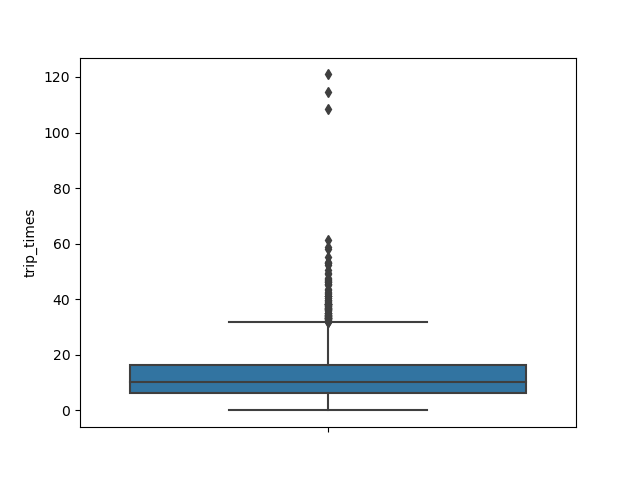

In [9]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()
#the following graph not interpratable so plot pdf

In [10]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 4.033333333333333
20 percentile value is 5.7
30 percentile value is 7.166666666666667
40 percentile value is 8.683333333333334
50 percentile value is 10.333333333333334
60 percentile value is 12.533333333333333
70 percentile value is 14.9
80 percentile value is 18.45
90 percentile value is 24.733333333333334
100 percentile value is  120.91666666666667


In [11]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 24.733333333333334
91 percentile value is 25.433333333333334
92 percentile value is 26.483333333333334
93 percentile value is 27.383333333333333
94 percentile value is 28.6
95 percentile value is 30.233333333333334
96 percentile value is 32.71666666666667
97 percentile value is 35.88333333333333
98 percentile value is 38.46666666666667
99 percentile value is 46.31666666666667
100 percentile value is  120.91666666666667


In [12]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]#NY Authority rule the max travel is 12 hour=720min

In [13]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

<IPython.core.display.Javascript object>


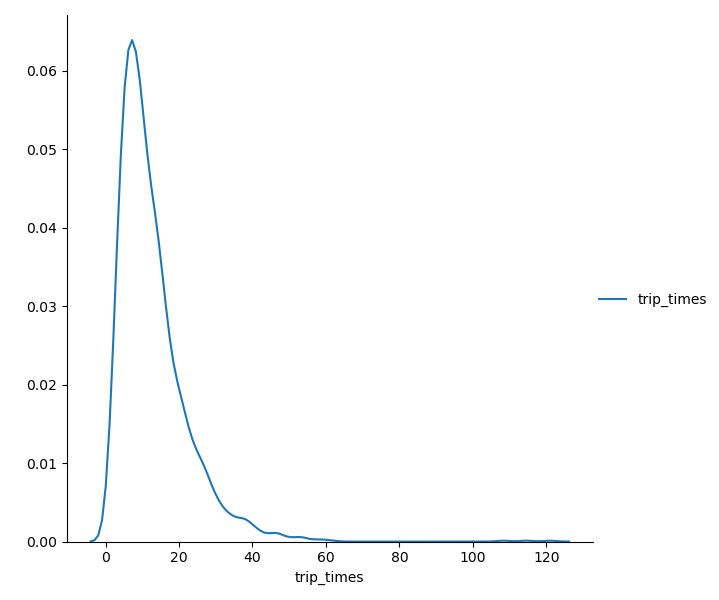

In [14]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();
#its right skewed so tale log which is normally distributed between -3 t0 3.

In [15]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<IPython.core.display.Javascript object>


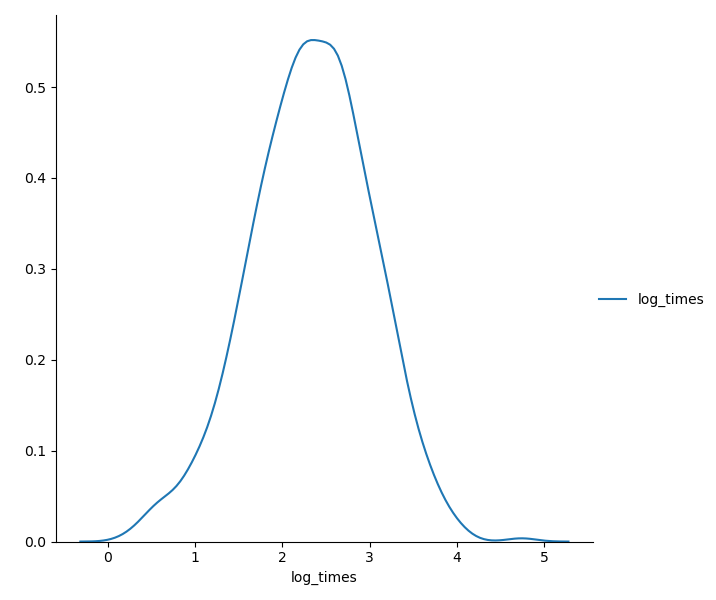

In [16]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

In [17]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

### 4. Speed

In [18]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [19]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.286098052384151
20 percentile value is 7.65143464399575
30 percentile value is 8.70967741935484
40 percentile value is 9.78397212543554
50 percentile value is 10.852713178294572
60 percentile value is 12.02385685884692
70 percentile value is 13.5678391959799
80 percentile value is 15.809885931558934
90 percentile value is 19.87730061349693
100 percentile value is  50.4950495049505


In [20]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 19.87730061349693
91 percentile value is 20.48780487804878
92 percentile value is 21.28440366972477
93 percentile value is 22.54103343465046
94 percentile value is 23.642147117296222
95 percentile value is 24.964355152300712
96 percentile value is 26.257928118393234
97 percentile value is 28.799999999999997
98 percentile value is 31.438797423049387
99 percentile value is 35.96558317399618
100 percentile value is  50.4950495049505


In [21]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.96558317399618
99.1 percentile value is 36.15711947626841
99.2 percentile value is 36.557522123893804
99.3 percentile value is 37.561547479484176
99.4 percentile value is 39.38730853391685
99.5 percentile value is 40.143435511856566
99.6 percentile value is 42.96377306903623
99.7 percentile value is 44.2867924528302
99.8 percentile value is 46.55555555555556
99.9 percentile value is 49.05037159372419
100 percentile value is  50.4950495049505


In [22]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

In [23]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.27111867940314

<b style='font-size:16px'>The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

### 4. Trip Distance

In [24]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [25]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.7
20 percentile value is 0.9
30 percentile value is 1.2
40 percentile value is 1.4
50 percentile value is 1.7
60 percentile value is 2.1
70 percentile value is 2.72
80 percentile value is 3.7
90 percentile value is 6.4
100 percentile value is  28.66


In [26]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.4
91 percentile value is 6.9
92 percentile value is 7.47
93 percentile value is 7.93
94 percentile value is 8.62
95 percentile value is 9.47
96 percentile value is 10.2
97 percentile value is 11.26
98 percentile value is 15.05
99 percentile value is 18.1
100 percentile value is  28.66


In [27]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.1
99.1 percentile value is 18.3
99.2 percentile value is 18.4
99.3 percentile value is 18.75
99.4 percentile value is 19.28
99.5 percentile value is 19.7
99.6 percentile value is 20.0
99.7 percentile value is 20.58
99.8 percentile value is 21.1
99.9 percentile value is 26.08
100 percentile value is  28.66


In [28]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

In [29]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 5. Total Fare

In [30]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [31]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.3
10 percentile value is 6.8
20 percentile value is 7.8
30 percentile value is 9.2
40 percentile value is 10.3
50 percentile value is 11.6
60 percentile value is 13.3
70 percentile value is 15.35
80 percentile value is 19.3
90 percentile value is 27.8
100 percentile value is  132.18


In [32]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.8
91 percentile value is 29.75
92 percentile value is 31.3
93 percentile value is 33.3
94 percentile value is 35.13
95 percentile value is 37.3
96 percentile value is 41.21
97 percentile value is 47.15
98 percentile value is 58.13
99 percentile value is 63.36
100 percentile value is  132.18


In [33]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 63.36
99.1 percentile value is 65.13
99.2 percentile value is 67.13
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.73
99.6 percentile value is 71.13
99.7 percentile value is 72.46
99.8 percentile value is 81.8
99.9 percentile value is 98.64
100 percentile value is  132.18


<b>Observation:-</b> As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

In [34]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

In [35]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

In [36]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers/erronous points.

In [37]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [38]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  1999
Number of outlier coordinates lying outside NY boundaries: 52
Number of outliers from trip times analysis: 3
Number of outliers from trip distance analysis: 18
Number of outliers from speed analysis: 6
Number of outliers from fare analysis: 0
Total outliers removed 72
---
fraction of data points that remain after removing outliers 0.9639819909954978


# Data-preperation
## Clustering/Segmentation

In [39]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.8193991884965207 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 6.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 14.0 
Min inter-cluster distance =  0.5340049437236285 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 6.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 24.0 
Min inter-cluster distance =  0.49224744958799105 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 11.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 29.0 
Min inter-cluster distanc

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got was 40

In [40]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [41]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

<IPython.core.display.Javascript object>


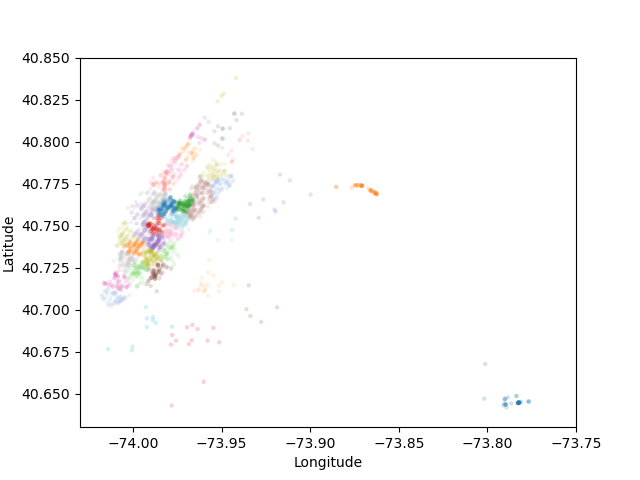

In [42]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## Time-binning

In [43]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [44]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [45]:
# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min intravel the trip belongs to)
jan_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421329e+09,5.285319,19,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420902e+09,9.983193,11,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420902e+09,10.746269,25,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420902e+09,16.071429,24,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420902e+09,9.318378,9,1419


In [46]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              7                        1
               33                       1
               258                      3
               259                      1
               341                      1

In [47]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  1999
Number of outlier coordinates lying outside NY boundaries: 41
Number of outliers from trip times analysis: 13
Number of outliers from trip distance analysis: 21
Number of outliers from speed analysis: 9
Number of outliers from fare analysis: 2
Total outliers removed 68
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  1999
Number of outlier coordinates lying outside NY boundaries: 47
Number of outliers from trip times analysis: 9
Number of outliers from trip distance analysis: 18
Number of outliers from speed analysis: 8
Number of outliers from fare analysis: 0
Total outliers removed 65
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  2013
Number of outlier coordinates lying outside NY boundaries: 19
Number of outliers from trip times analysis: 5
Number of outliers from trip dista

## Smoothing

In [48]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [49]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [50]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  4393
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  4440
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  4424
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  4418
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  4422
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  4431
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  4435
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  44

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [51]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [52]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [53]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [54]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  178560


<IPython.core.display.Javascript object>


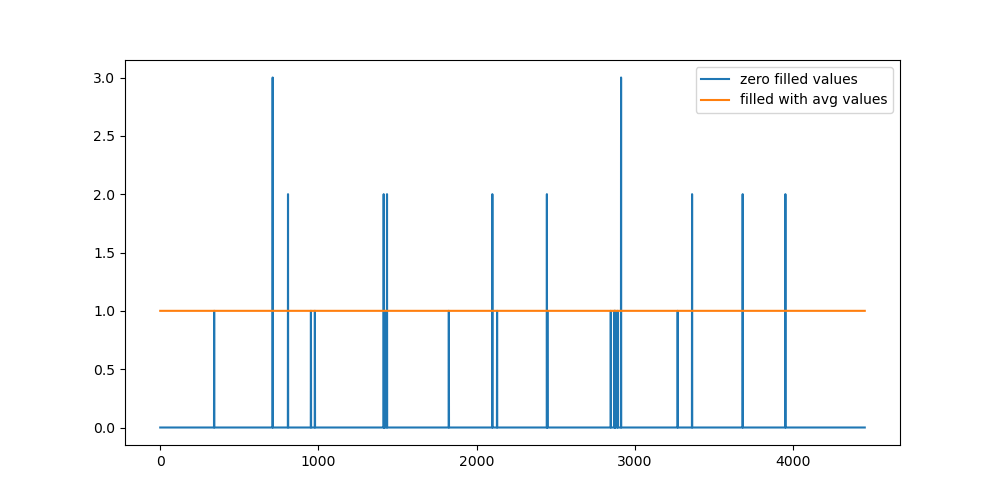

In [55]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [56]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

In [57]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 13104

## Time series and Fourier Transforms

<IPython.core.display.Javascript object>


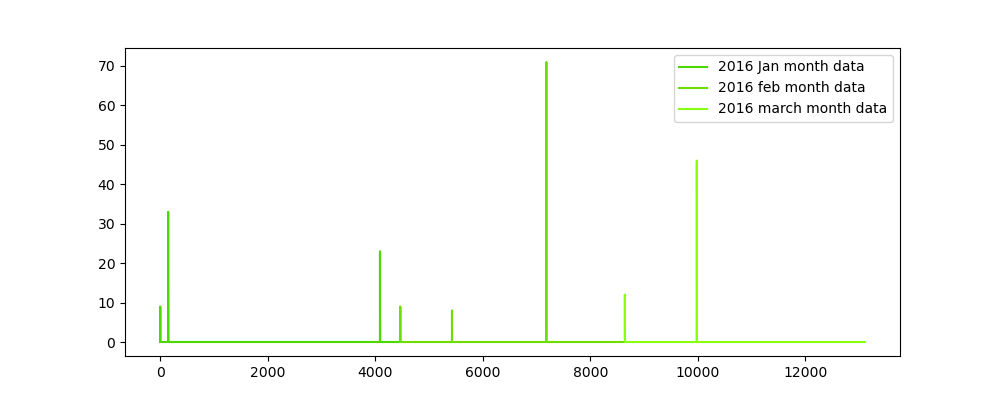

<IPython.core.display.Javascript object>


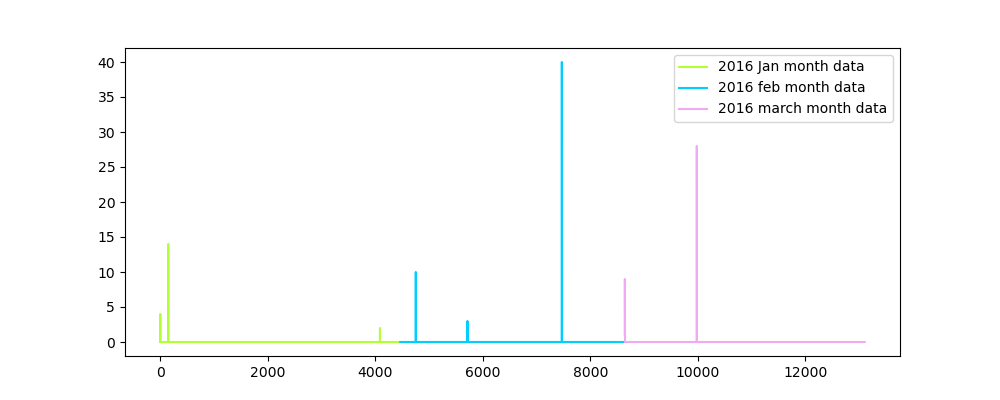

<IPython.core.display.Javascript object>


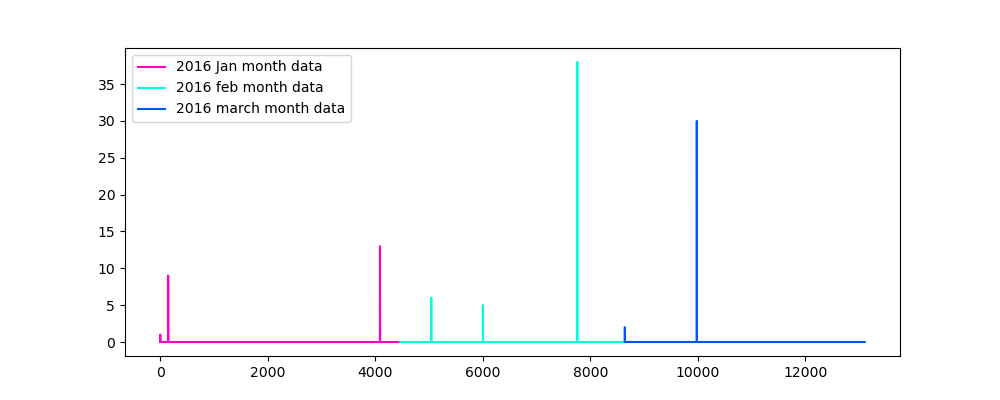

<IPython.core.display.Javascript object>


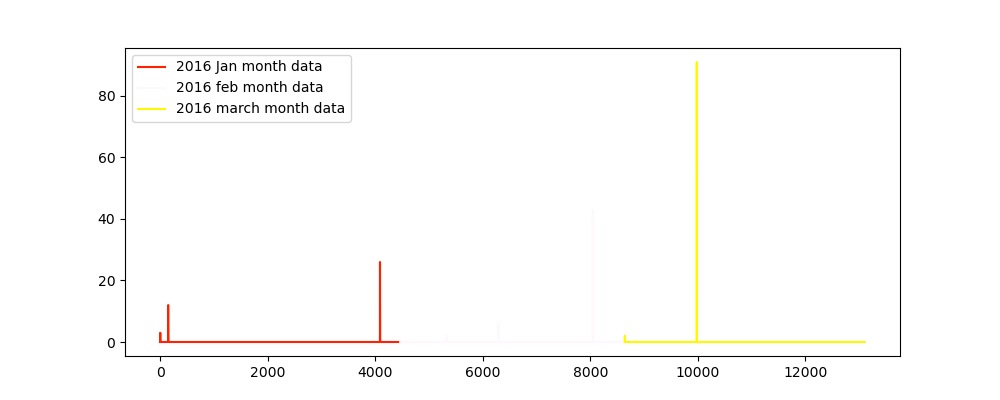

<IPython.core.display.Javascript object>


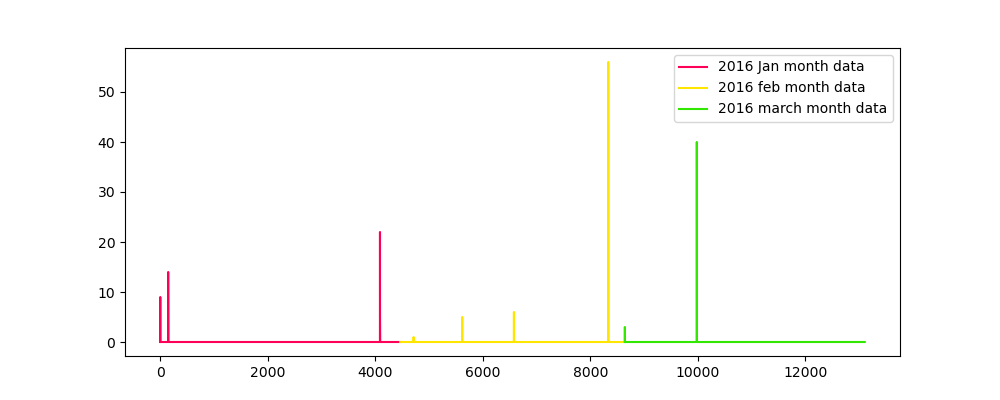

<IPython.core.display.Javascript object>


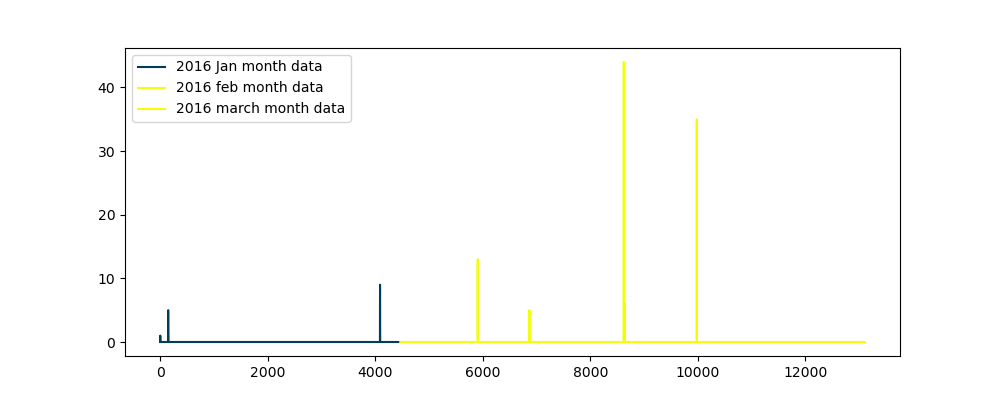

<IPython.core.display.Javascript object>


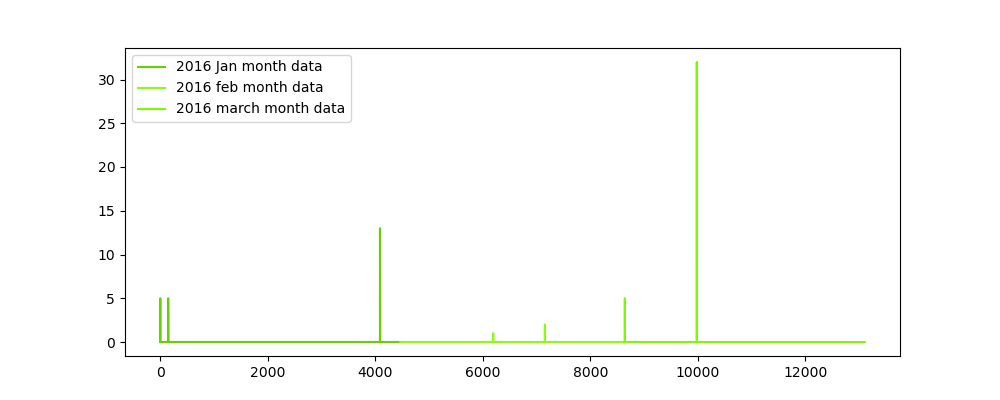

<IPython.core.display.Javascript object>


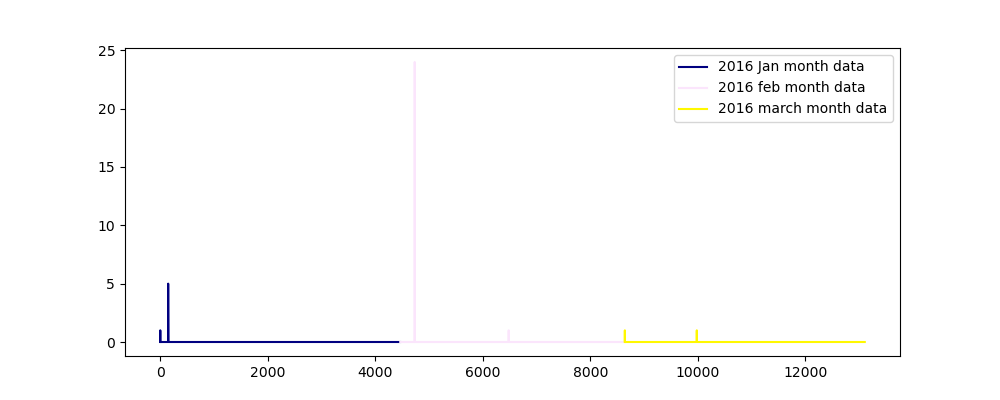

<IPython.core.display.Javascript object>


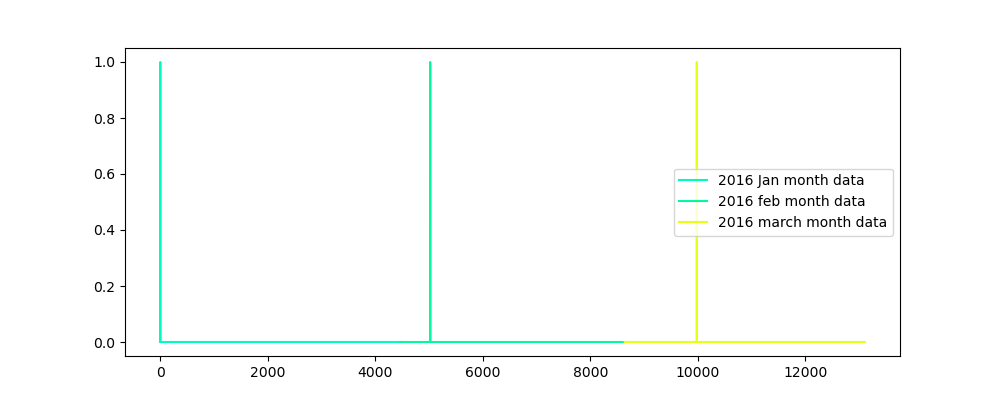

<IPython.core.display.Javascript object>


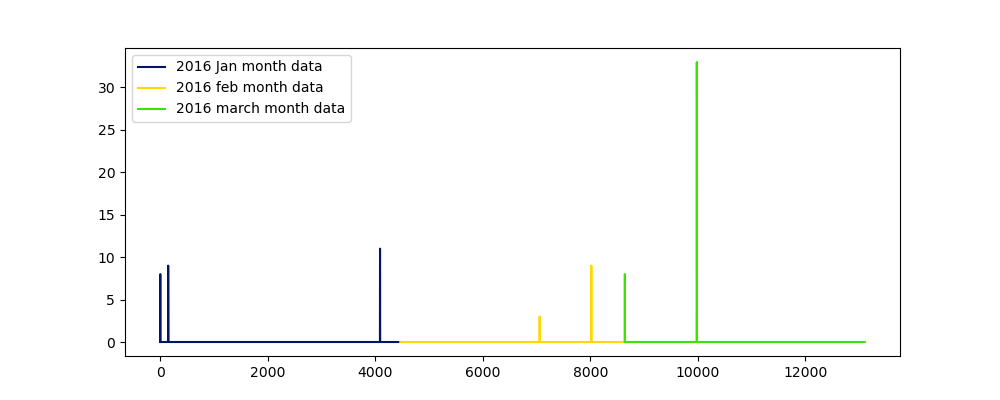

<IPython.core.display.Javascript object>


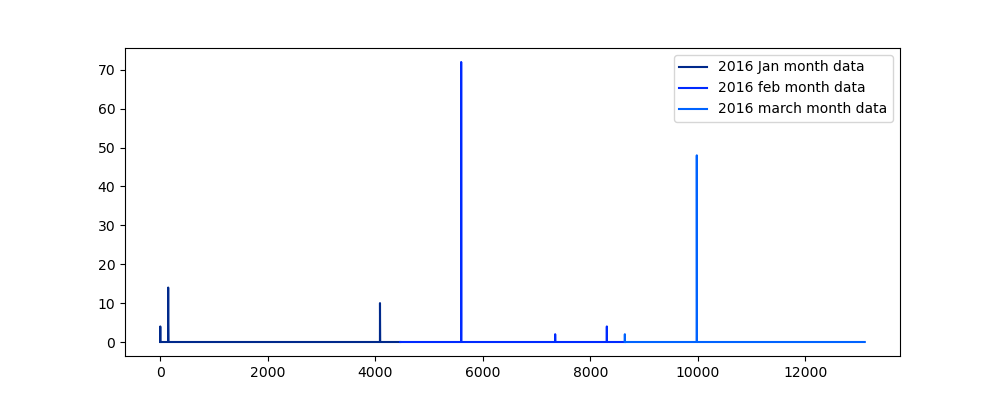

<IPython.core.display.Javascript object>


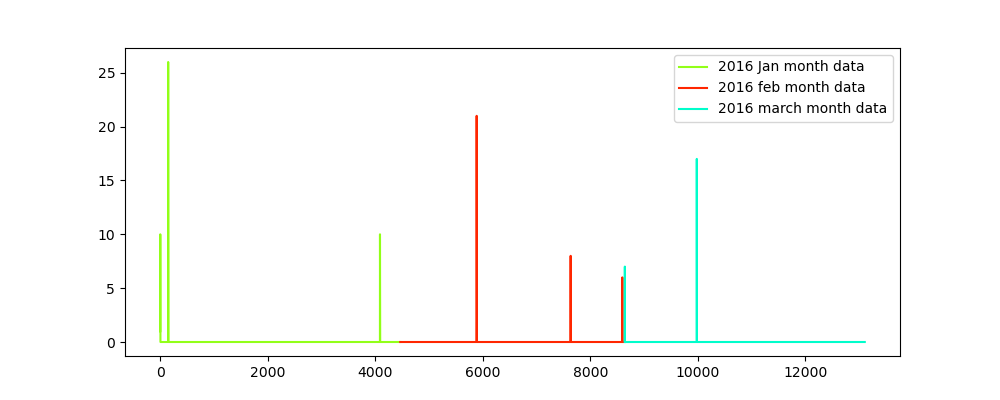

<IPython.core.display.Javascript object>


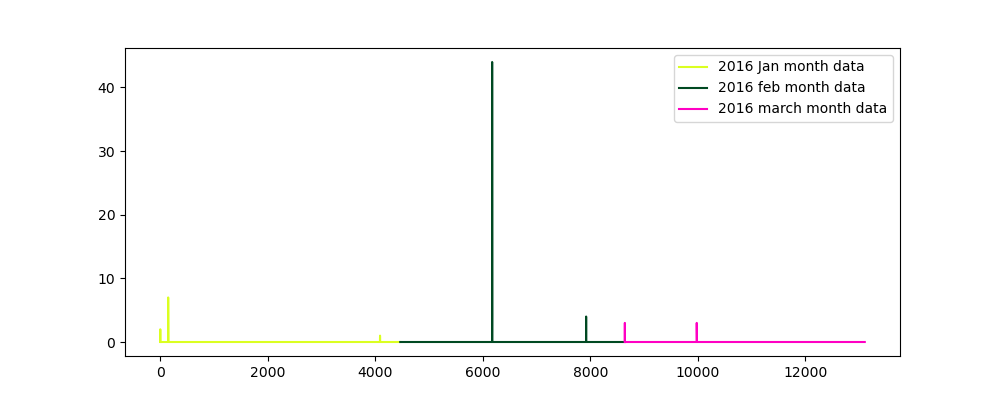

<IPython.core.display.Javascript object>


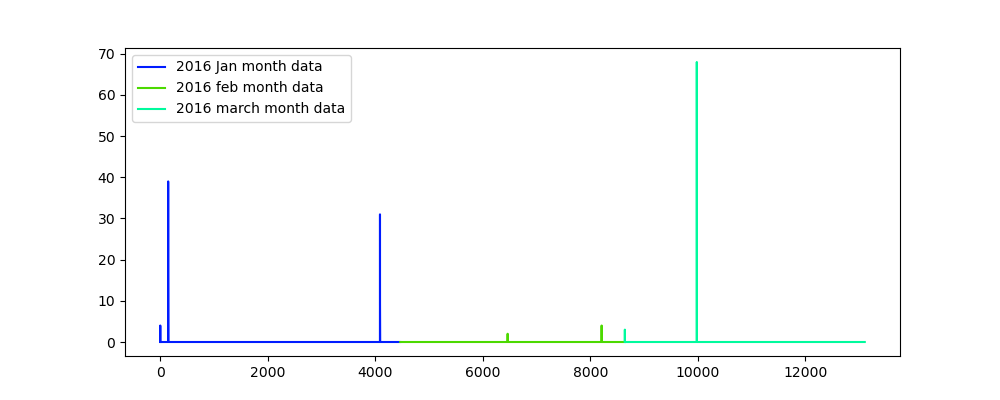

<IPython.core.display.Javascript object>


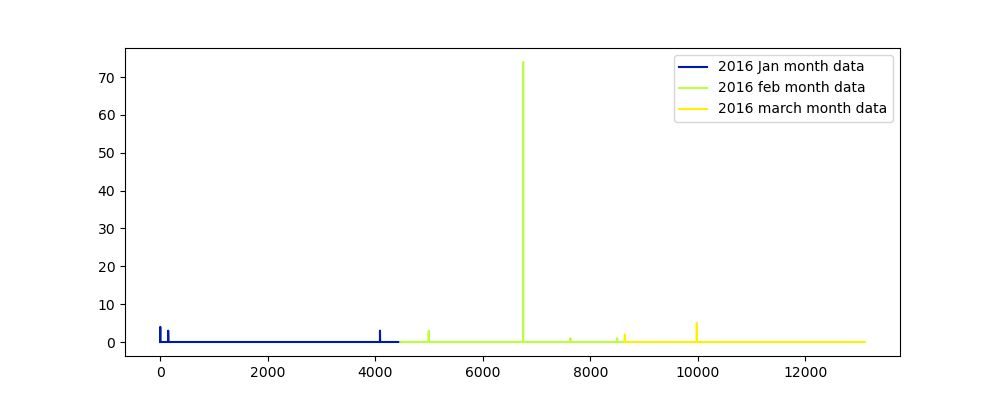

<IPython.core.display.Javascript object>


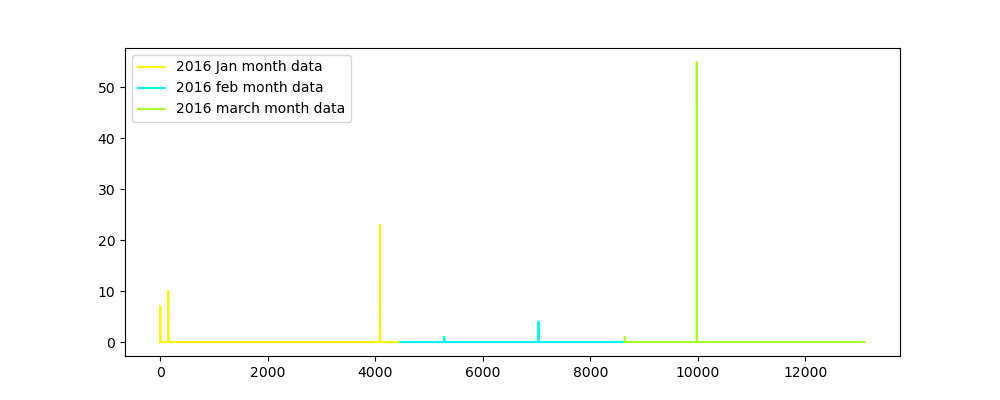

<IPython.core.display.Javascript object>


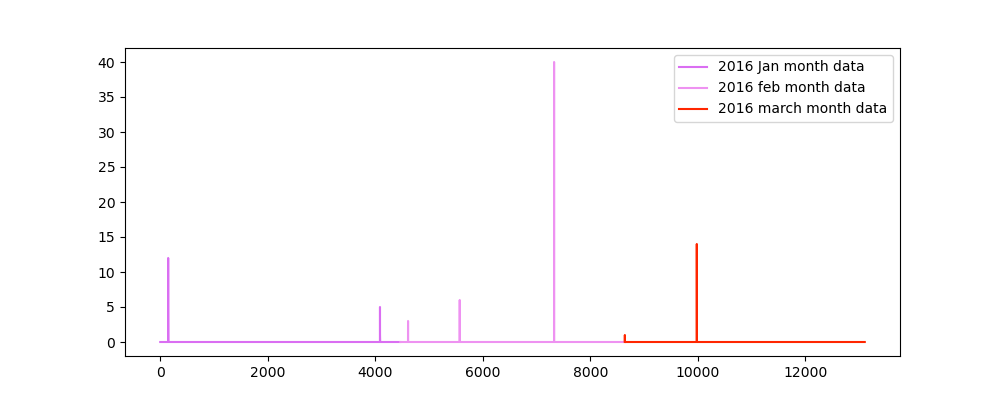

<IPython.core.display.Javascript object>


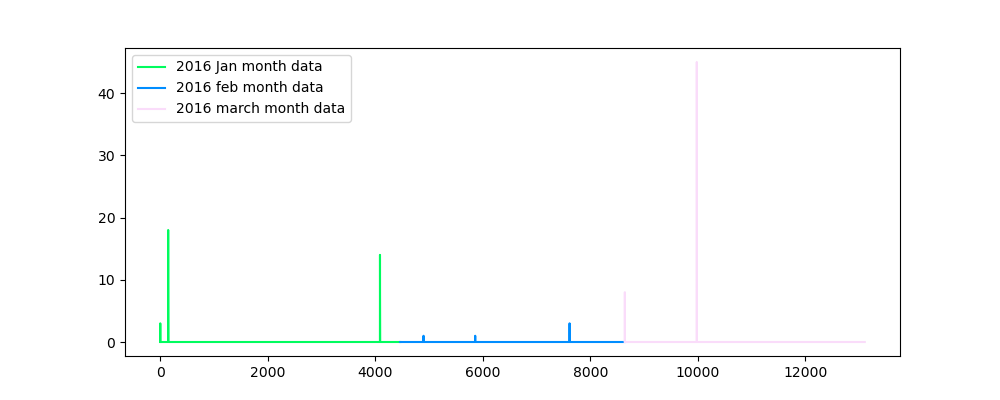

<IPython.core.display.Javascript object>


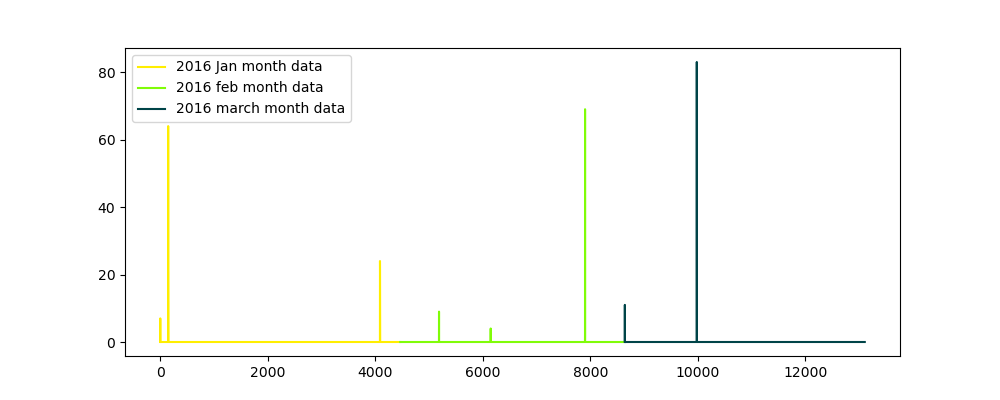

<IPython.core.display.Javascript object>


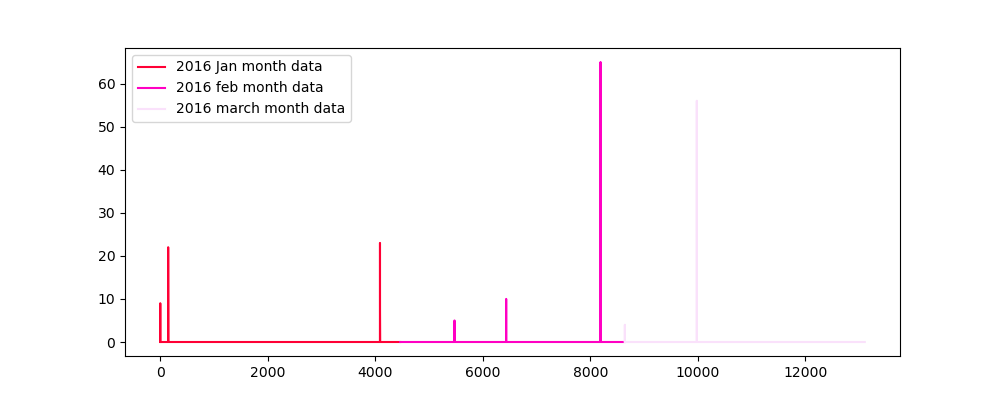

<IPython.core.display.Javascript object>


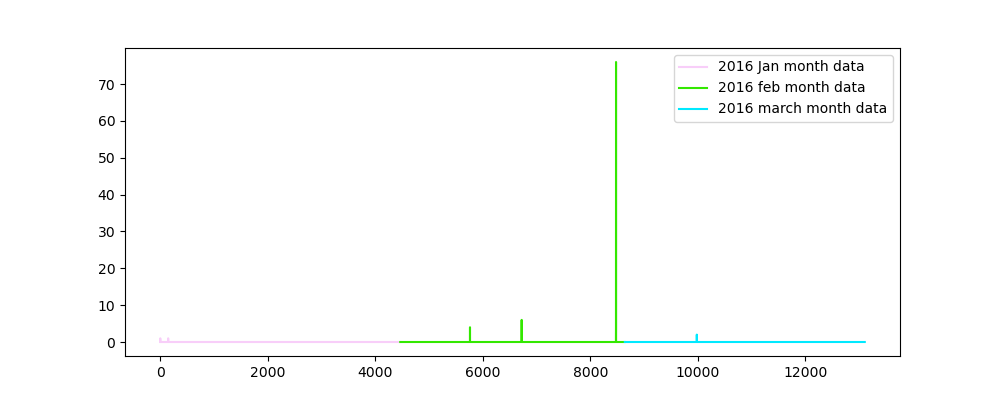

<IPython.core.display.Javascript object>


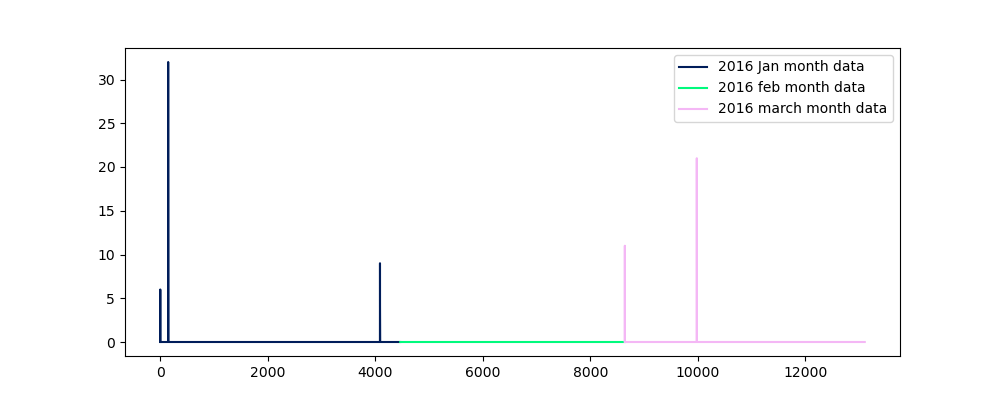

<IPython.core.display.Javascript object>


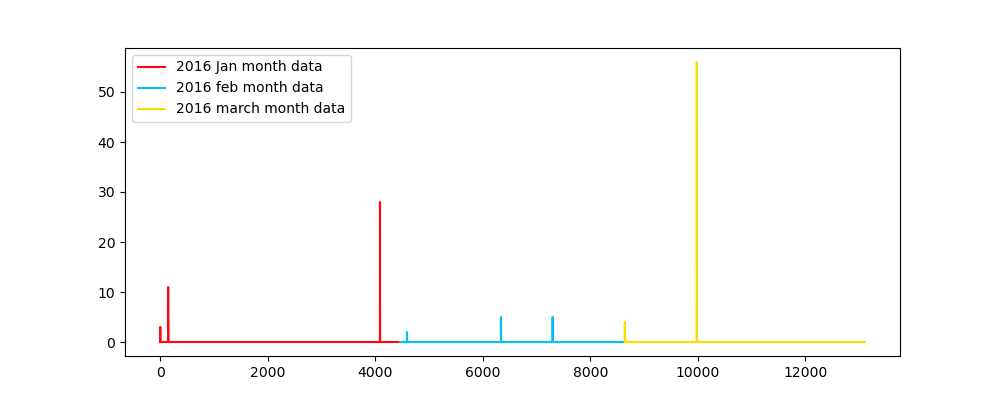

<IPython.core.display.Javascript object>


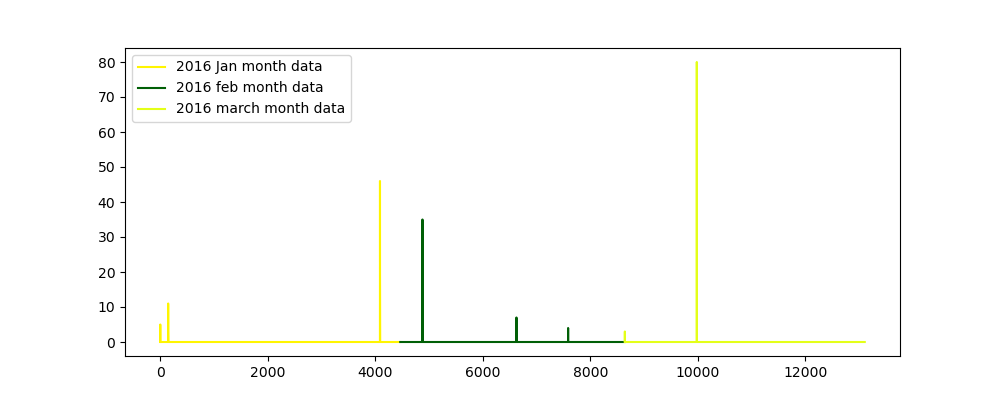

<IPython.core.display.Javascript object>


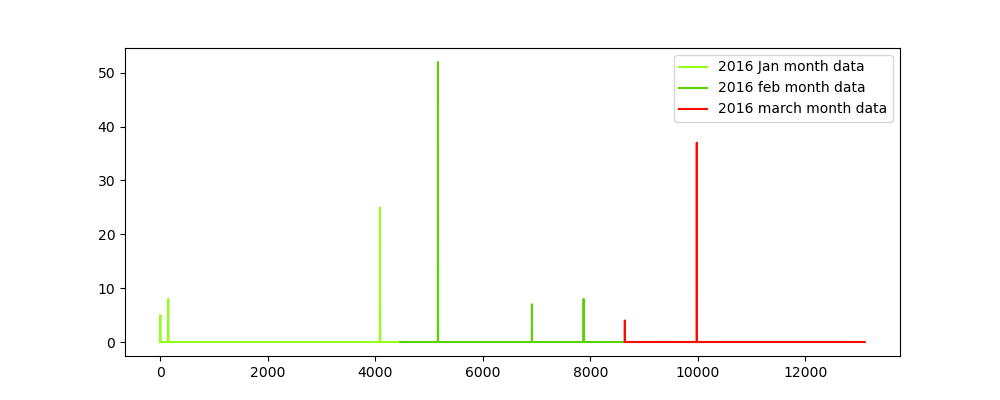

<IPython.core.display.Javascript object>


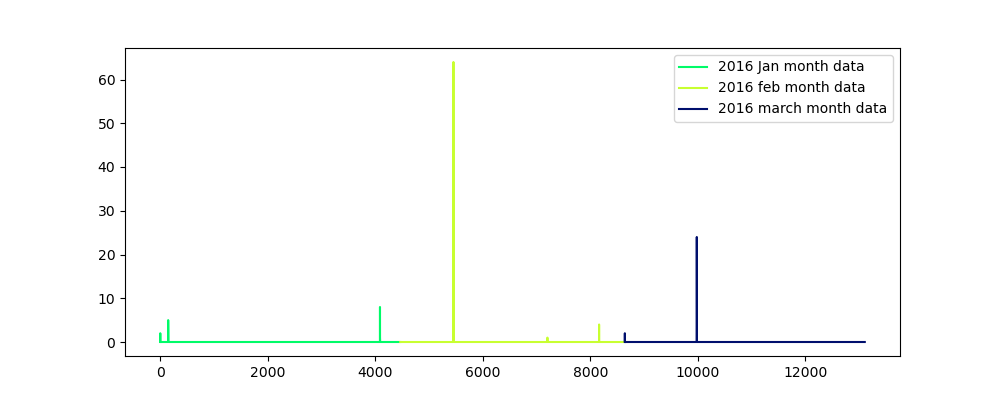

<IPython.core.display.Javascript object>


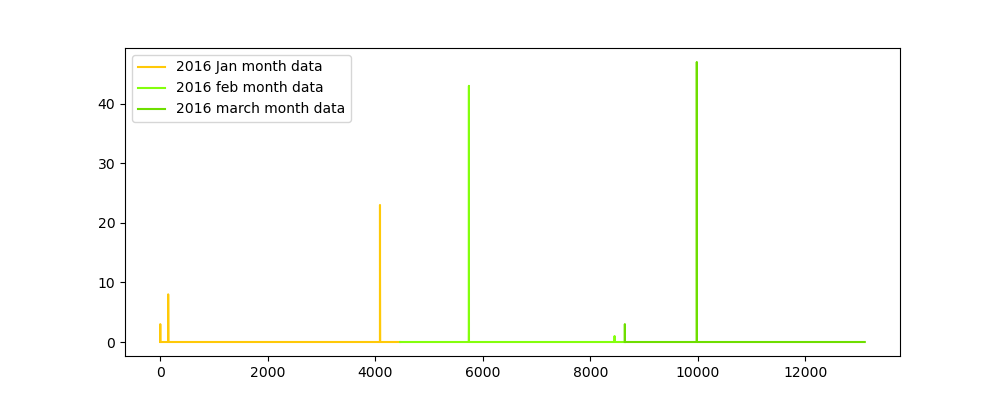

<IPython.core.display.Javascript object>


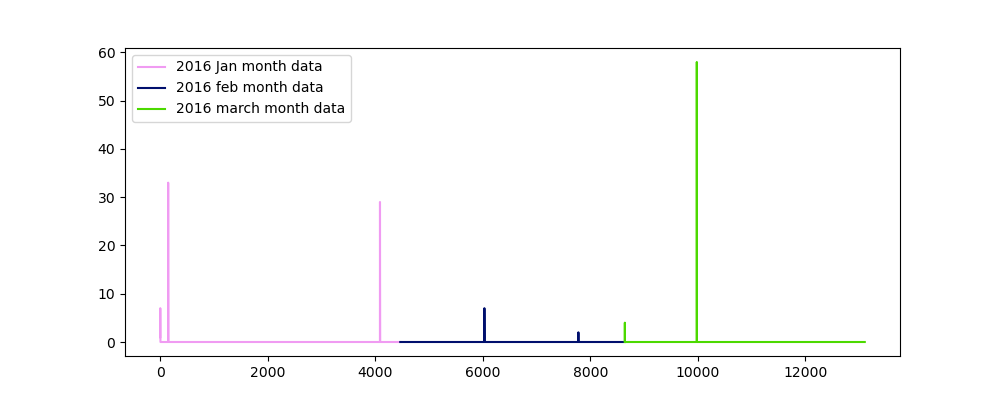

<IPython.core.display.Javascript object>


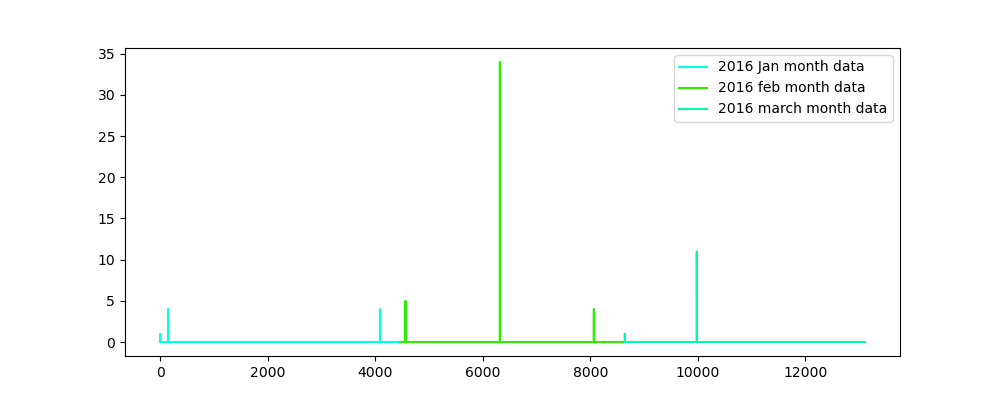

<IPython.core.display.Javascript object>


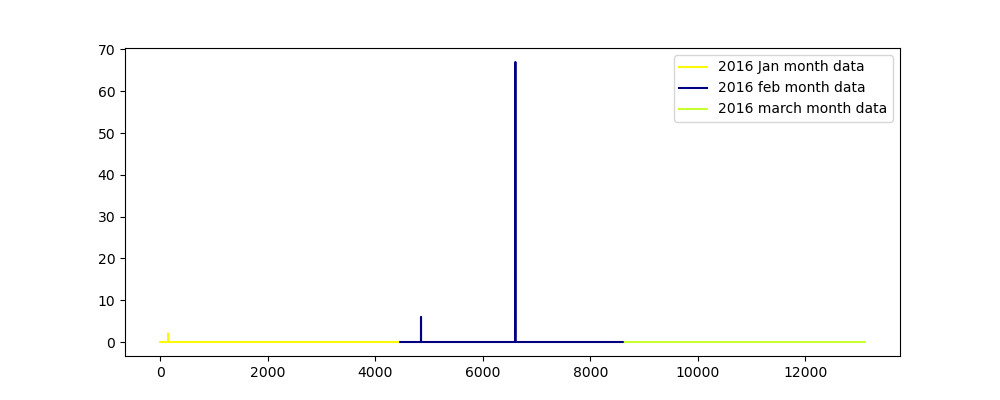

<IPython.core.display.Javascript object>


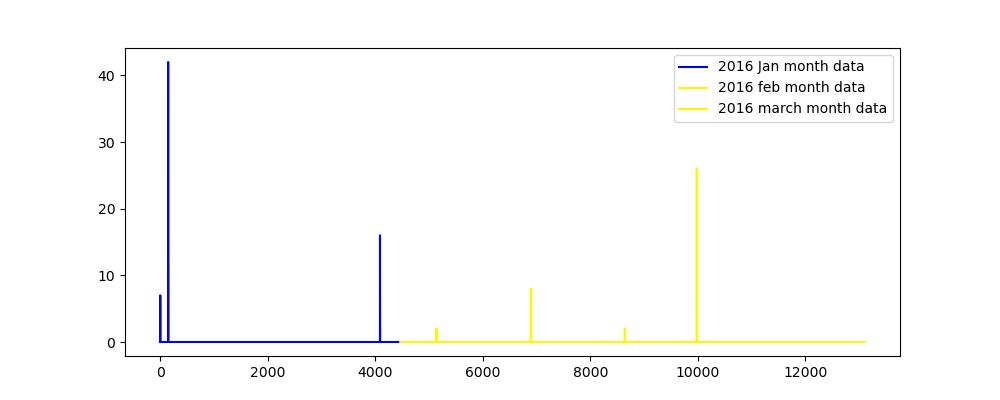

<IPython.core.display.Javascript object>


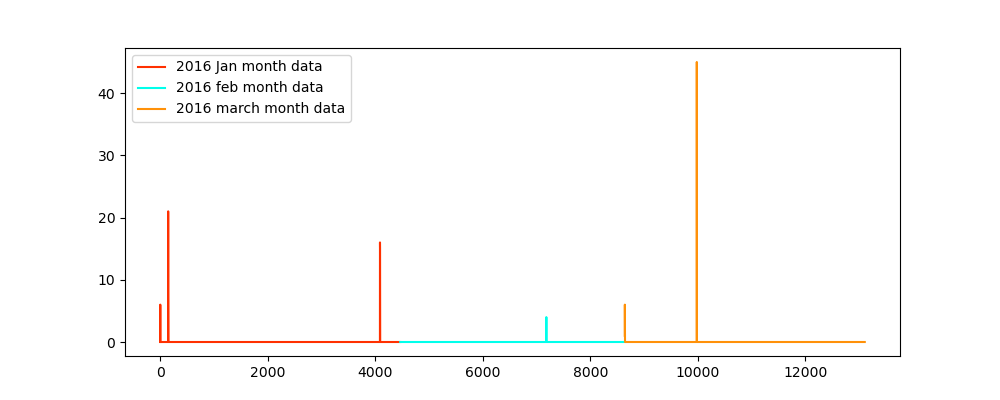

<IPython.core.display.Javascript object>


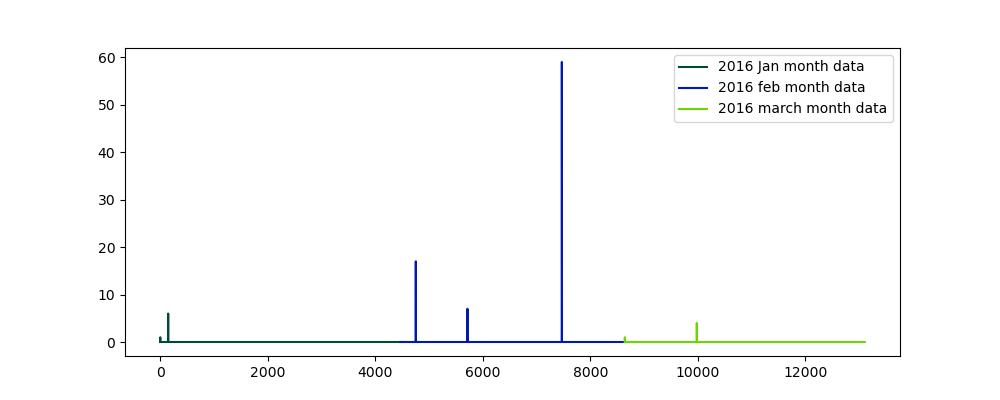

<IPython.core.display.Javascript object>


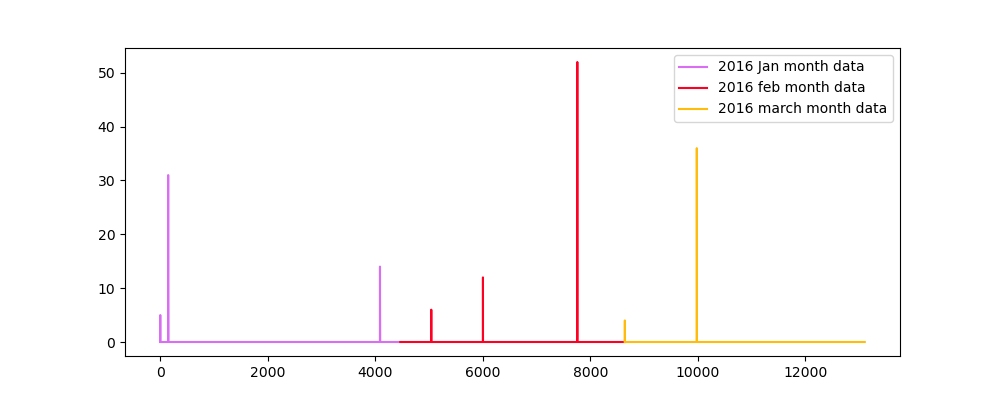

<IPython.core.display.Javascript object>


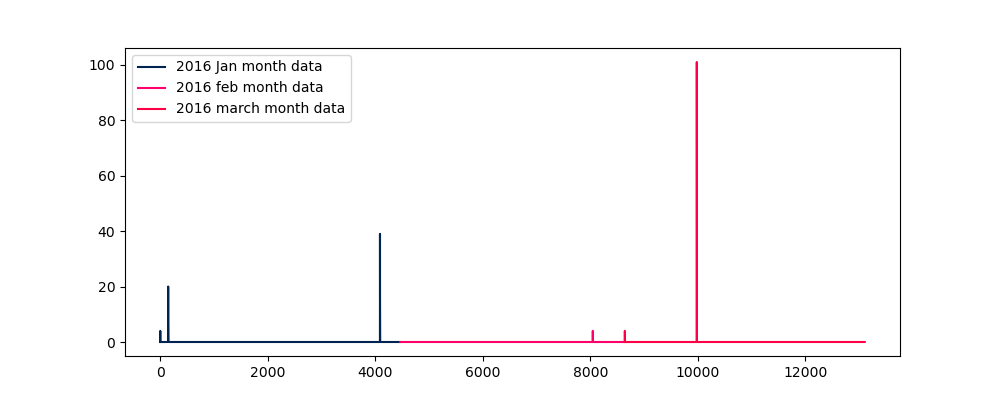

<IPython.core.display.Javascript object>


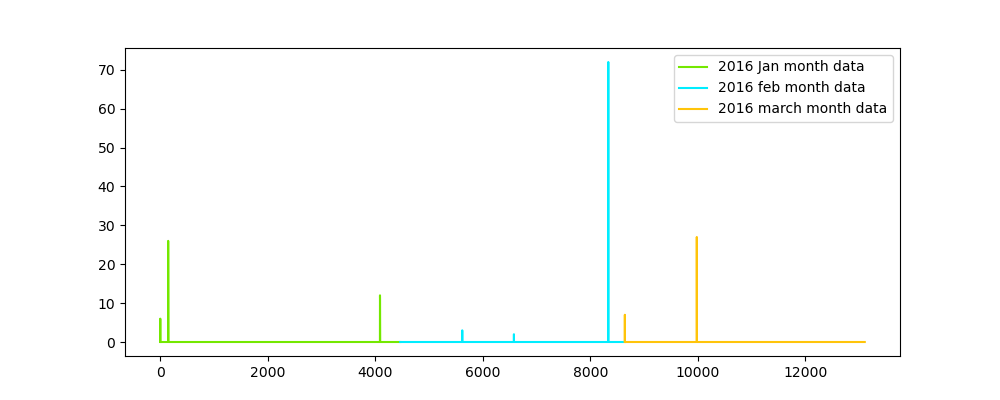

<IPython.core.display.Javascript object>


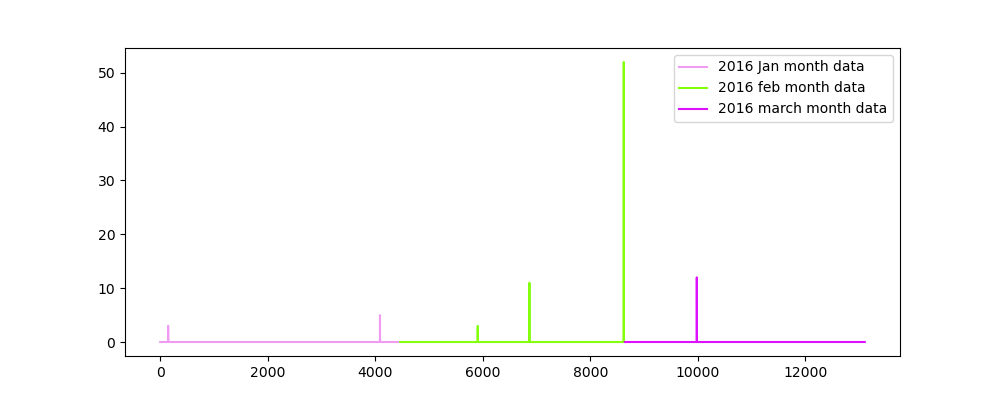

<IPython.core.display.Javascript object>


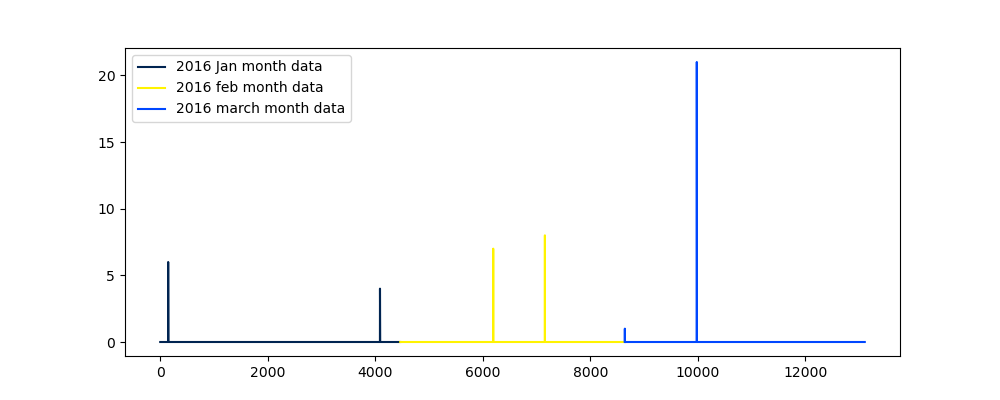

<IPython.core.display.Javascript object>


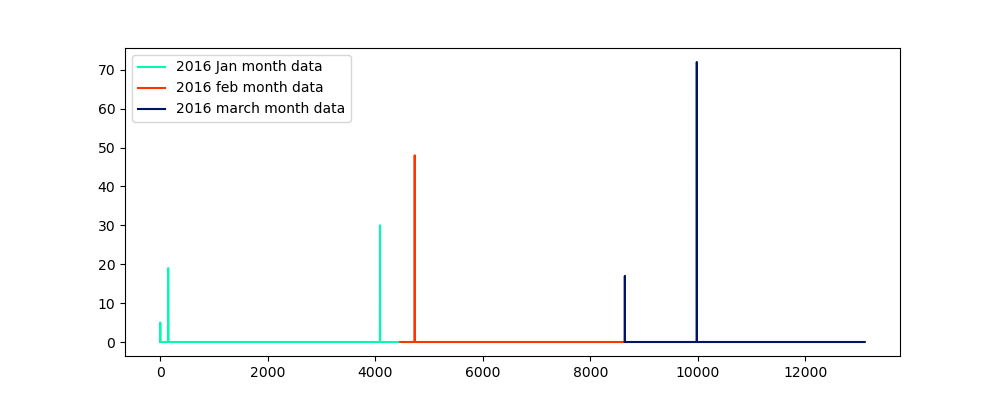

<IPython.core.display.Javascript object>


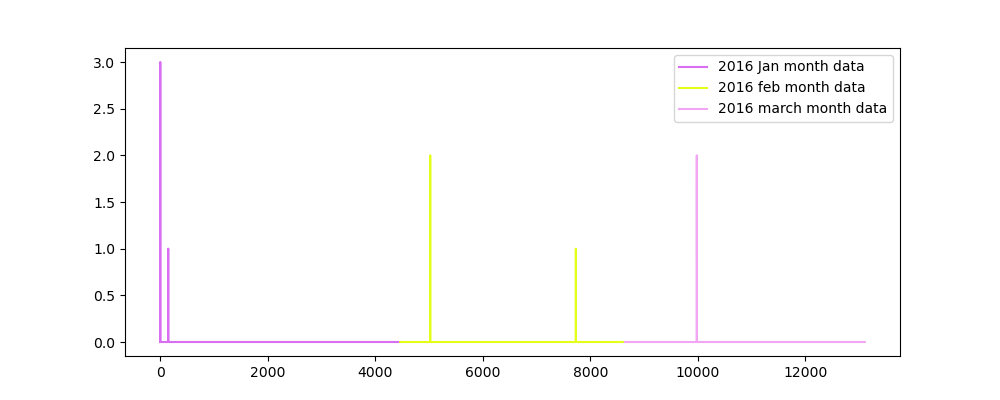

In [58]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


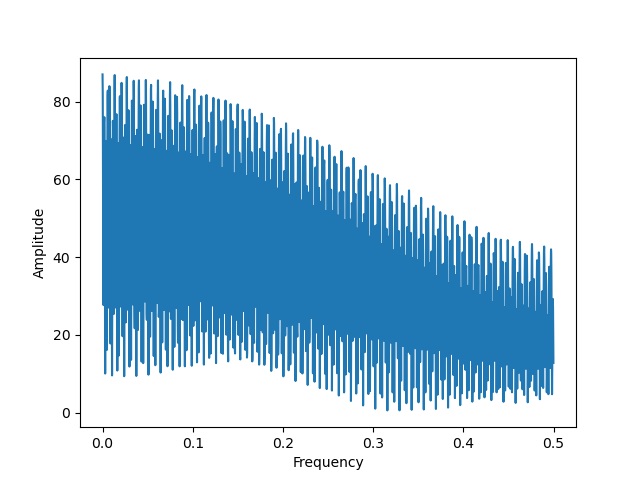

In [59]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [60]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [61]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [62]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 1 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [63]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [65]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous 2016 values therefore we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [66]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [67]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [69]:
mean_err=[0]*3
median_err=[0]*3
ratios_jan,mean_err[0],median_err[0]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=EA_P1_Predictions(ratios_jan,'jan')

## Comparison between baseline models
We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know that on an average how good is our model with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of a error margin between our prediction and the actual value

In [70]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[0],"       MSE: ",median_err[0])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[1],"      MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (2016 Values) -            MAPE: ",mean_err[2],"      MSE: ",median_err[2])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (2016 Values) -                        MAPE:  1.3920248575867429        MSE:  0.2743503584229391
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (2016 Values) -               MAPE:  1.3889176592439152       MSE:  0.2622311827956989
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (2016 Values) -            MAPE:  1.3055411703780424       MSE:  0.2404513888888889


<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

<IPython.core.display.Javascript object>


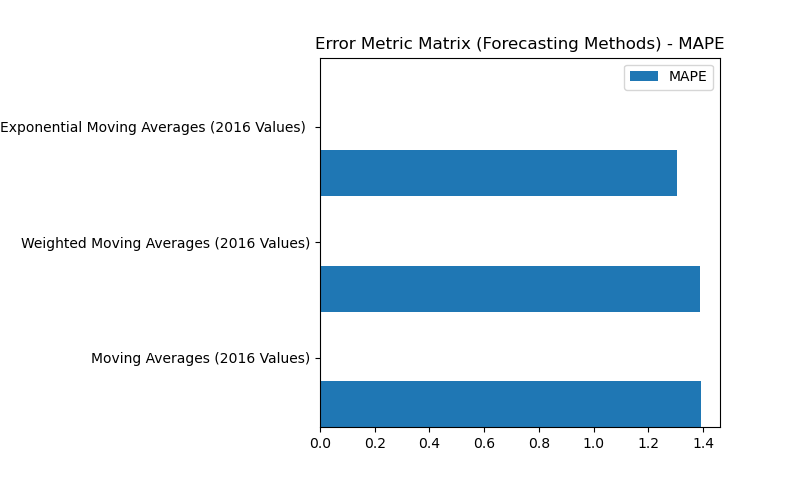

<IPython.core.display.Javascript object>


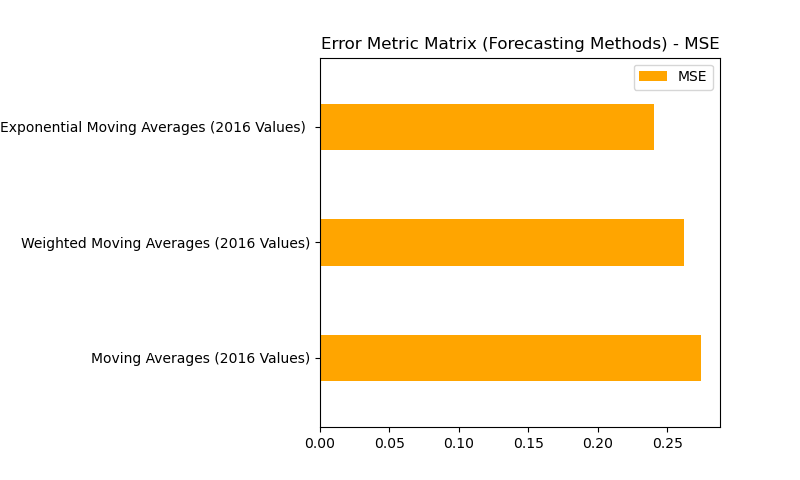

In [71]:
df = pd.DataFrame(dict(graph=['Moving Averages (2016 Values)' ,'Weighted Moving Averages (2016 Values)','Exponential Moving Averages (2016 Values) '],n
                       =mean_err, m=median_err)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, label='MAPE')
#ax.barh(ind + width, df.m, width, label='MSE')
fig.set_figwidth(8)
plt.gcf().subplots_adjust(left = 0.40)
plt.title("Error Metric Matrix (Forecasting Methods) - MAPE")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()

plt.show()

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
#ax.barh(ind, df.n, width, label='MAPE')
ax.barh(ind + width, df.m, width, color="orange", label='MSE')
fig.set_figwidth(8)
plt.gcf().subplots_adjust(left = 0.40)
plt.title("Error Metric Matrix (Forecasting Methods) - MSE")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()

plt.show()

From the above matrix it is inferred that the best forecasting model for our prediction would be:-
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e Exponential Moving Averages using 2016 Values

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [72]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [73]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [74]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
fr_am_final = pd.DataFrame(columns= ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for r in range(0,40):
    YJan = np.fft.fft(np.array(regions_cum[r][0:4464]))
    freqJan = np.fft.fftfreq((4464), 1)

    
    YFeb = np.fft.fft(np.array(regions_cum[r])[4464:(4176+4464)])
    freqFeb = np.fft.fftfreq((4176), 1)

    
    YMar = np.fft.fft(np.array(regions_cum[r])[(4176+4464):(4176+4464+4464)])
    freqMar = np.fft.fftfreq((4464), 1)

    fr_am_jan = pd.DataFrame()
    fr_am_feb = pd.DataFrame()
    fr_am_mar = pd.DataFrame()
    
    fr_am_jan['Frequency'] = freqJan
    fr_am_jan['Amplitude'] = YJan
    fr_am_feb['Frequency'] = freqFeb
    fr_am_feb['Amplitude'] = YFeb
    fr_am_mar['Frequency'] = freqMar
    fr_am_mar['Amplitude'] = YMar
    
    fr_am_list_jan = []
    fr_am_list_feb = []
    fr_am_list_mar = []
    
    fr_am_jan_sorted = fr_am_jan.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    fr_am_feb_sorted = fr_am_feb.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    fr_am_mar_sorted = fr_am_mar.sort_values(by=["Amplitude"], ascending=False)[:5].reset_index(drop=True).T
    
    for i in range(0,5):
        fr_am_list_jan.append(float(fr_am_jan_sorted[i]['Frequency']))
        fr_am_list_jan.append(float(fr_am_jan_sorted[i]['Amplitude']))

        fr_am_list_feb.append(float(fr_am_feb_sorted[i]['Frequency']))
        fr_am_list_feb.append(float(fr_am_feb_sorted[i]['Amplitude']))

        fr_am_list_mar.append(float(fr_am_mar_sorted[i]['Frequency']))
        fr_am_list_mar.append(float(fr_am_mar_sorted[i]['Amplitude']))

    fr_am_new_jan = pd.DataFrame([fr_am_list_jan]*4464)
    fr_am_new_feb = pd.DataFrame([fr_am_list_feb]*4176)
    fr_am_new_mar = pd.DataFrame([fr_am_list_mar]*4464)

    fr_am_new_jan.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    fr_am_new_feb.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    fr_am_new_mar.columns = ['f_1','a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5',]
    
    
    fr_am_final = fr_am_final.append(fr_am_new_jan, ignore_index=True)
    fr_am_final = fr_am_final.append(fr_am_new_feb, ignore_index=True)
    fr_am_final = fr_am_final.append(fr_am_new_mar, ignore_index=True)
    
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [75]:
fr_am_final.head(5)

,f_1,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,0.0,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
1,0.0,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
2,0.0,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
3,0.0,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
4,0.0,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713


In [76]:
fr_am_final.drop(['f_1'],axis=1,inplace=True)

fr_am_final = fr_am_final # (fr_am_final - fr_am_final.mean()) / (fr_am_final.max() - fr_am_final.min())
fr_am_final = fr_am_final.fillna(0)

In [77]:
fr_am_final.head(5)

,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
1,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
2,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
3,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713
4,87.0,0.013217,85.180345,-0.013217,85.180345,-0.013441,84.474713,0.013441,84.474713


In [78]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [79]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]
fr_am_final_train = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
fr_am_final_test = pd.DataFrame(columns=['a_1','f_2','a_2','f_3','a_3','f_4','a_4','f_5','a_5'])
for i in range(0,40):
    fr_am_final_train = fr_am_final_train.append(fr_am_final[i*13099:(13099*i+9169)] )
fr_am_final_train.reset_index(inplace=True)
for i in range(0,40):
    fr_am_final_test = fr_am_final_test.append(fr_am_final[(13099*(i))+9169:13099*(i+1)])
fr_am_final_test.reset_index(inplace=True)

In [80]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [81]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [82]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [83]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [84]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [85]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [86]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 9)


In [87]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 9)


In [88]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg
0,0,0,0,0,0,40.761064,-73.980841,4,0
1,0,0,0,0,0,40.761064,-73.980841,4,0
2,0,0,0,0,0,40.761064,-73.980841,4,0
3,0,0,0,0,0,40.761064,-73.980841,4,0
4,0,0,0,0,0,40.761064,-73.980841,4,0


In [89]:
df_test_lm = pd.concat([df_test, fr_am_final_test], axis=1)
df_train_lm = pd.concat([df_train, fr_am_final_train], axis=1)

df_test_lm.head()
print(df_test.shape)
print(fr_am_final_test.shape)

(157200, 9)
(157200, 10)


In [90]:
df_test_lm.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon,weekday,exp_avg,index,a_1,f_2,a_2,f_3,a_3,f_4,a_4,f_5,a_5
0,0,0,0,0,0,40.761064,-73.980841,4,0,9169,70.0,0.00224,69.99706,-0.00224,69.99706,0.00448,69.988241,-0.00448,69.988241
1,0,0,0,0,0,40.761064,-73.980841,4,0,9170,70.0,0.00224,69.99706,-0.00224,69.99706,0.00448,69.988241,-0.00448,69.988241
2,0,0,0,0,0,40.761064,-73.980841,4,0,9171,70.0,0.00224,69.99706,-0.00224,69.99706,0.00448,69.988241,-0.00448,69.988241
3,0,0,0,0,0,40.761064,-73.980841,4,0,9172,70.0,0.00224,69.99706,-0.00224,69.99706,0.00448,69.988241,-0.00448,69.988241
4,0,0,0,0,0,40.761064,-73.980841,4,0,9173,70.0,0.00224,69.99706,-0.00224,69.99706,0.00448,69.988241,-0.00448,69.988241


### Using Linear Regression

In [91]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve, GridSearchCV

lr_reg=LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg,parameters, cv=None)
grid.fit(df_train, tsne_train_output)

print(grid.best_estimator_)
print(grid.best_params_)




LinearRegression(fit_intercept=False, normalize=True)
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [109]:
lr_reg=LinearRegression(copy_X=True, fit_intercept=True, normalize=True).fit(df_train, tsne_train_output)
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]
print("ACTUAL VALUES :\n",df_train["exp_avg"].head(10), " \n\n\n PREDICTED VALUES : \n")
for i in range (0,10):
    print(i,"",lr_train_predictions[i]) 

ACTUAL VALUES :
 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: exp_avg, dtype: int64  


 PREDICTED VALUES : 

0  0.0
1  -0.0
2  0.0
3  0.0
4  0.0
5  0.0
6  0.0
7  0.0
8  0.0
9  0.0


## Using Linear Regression with Fourier Transforms

In [93]:
lr_reg_lm=LinearRegression()

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr_reg_lm,parameters, cv=None)
grid.fit(df_train_lm, tsne_train_output)

print(grid.best_estimator_)
print(grid.best_params_)

LinearRegression(fit_intercept=False, normalize=True)
{'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [108]:
lr_reg_lm=LinearRegression(copy_X=True, fit_intercept=False, normalize=True).fit(df_train_lm, tsne_train_output)

y_pred_lm = lr_reg_lm.predict(df_test_lm)
lr_test_predictions_lm = [round(value) for value in y_pred_lm]
y_pred_lm = lr_reg_lm.predict(df_train_lm)
lr_train_predictions_lm = [round(value) for value in y_pred_lm]
print("ACTUAL VALUES :\n",df_train_lm["exp_avg"].head(10), " \n\n\n PREDICTED VALUES : \n")
for i in range (0,10):
    print(i,"",lr_train_predictions_lm[i])


ACTUAL VALUES :
 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: exp_avg, dtype: int64  


 PREDICTED VALUES : 

0  0.0
1  -0.0
2  0.0
3  0.0
4  0.0
5  0.0
6  0.0
7  0.0
8  0.0
9  0.0


### Using Random Forest Regressor

In [95]:
from random import randint
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [96]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor()#(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
param_dist = {"max_depth": [3, None],
              "max_features": ['sqrt' , 'log2' ],
              "min_samples_split": randint(2, 11),
              "min_samples_leaf": randint(1, 11),
              "n_estimators":[35,40,45]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regr1, param_distributions=param_dist,n_iter=n_iter_search)
random_search.fit(df_train, tsne_train_output)
print(random_search.best_params_)

{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 40}


In [97]:
print(random_search.best_params_)

{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 40}


In [107]:
regr1 = RandomForestRegressor(max_depth= None,max_features='log2',min_samples_leaf=4,min_samples_split=8,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)


y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]
print("ACTUAL VALUES :\n",df_train["exp_avg"].head(10), " \n\n\n PREDICTED VALUES : \n")
for i in range (0,10):
    print(i,"",rndf_train_predictions[i])

ACTUAL VALUES :
 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: exp_avg, dtype: int64  


 PREDICTED VALUES : 

0  0.0
1  0.0
2  0.0
3  0.0
4  0.0
5  0.0
6  0.0
7  0.0
8  0.0
9  0.0


In [101]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[7.41615971e-07 1.13790053e-02 9.14854628e-03 1.35362263e-01
 3.79947615e-01 5.65975634e-02 5.76299208e-02 5.98104945e-02
 2.90123850e-01]


### Calculating the error metric values for various models

In [102]:
train_mape=[]
test_mape=[]
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions_lm))/(sum(tsne_train_output)/len(tsne_train_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions_lm))/(sum(tsne_test_output)/len(tsne_test_output)))

## Result

In [105]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Error Metric Matrix (Tree Based Regression Methods) - MAPE "
ptable.field_names = ["Model",'MAPE_train','MAPE__test']
ptable.add_row(["Linear Regression - ",train_mape[1],test_mape[1]])
ptable.add_row(["Linear Regression with Fourier Transforms - ",train_mape[2],test_mape[2]])
ptable.add_row(["Random Forest Regression - ",train_mape[0],test_mape[0]])
ptable.add_row(["\n","\n","\n"])
print(ptable)
with open('NYC_Result.txt', 'w') as w:
 w.write(str(ptable))

+----------------------------------------------------------------------------------------+
|               Error Metric Matrix (Tree Based Regression Methods) - MAPE               |
+----------------------------------------------+--------------------+--------------------+
|                    Model                     |     MAPE_train     |     MAPE__test     |
+----------------------------------------------+--------------------+--------------------+
|             Linear Regression -              | 1.2827140549273022 | 1.1618942731277533 |
| Linear Regression with Fourier Transforms -  | 1.2832525578890683 | 1.1618942731277533 |
|         Random Forest Regression -           | 1.0856219709208401 | 0.9647577092511013 |
|                                              |                    |                    |
|                                              |                    |                    |
+----------------------------------------------+--------------------+--------------------+

<IPython.core.display.Javascript object>


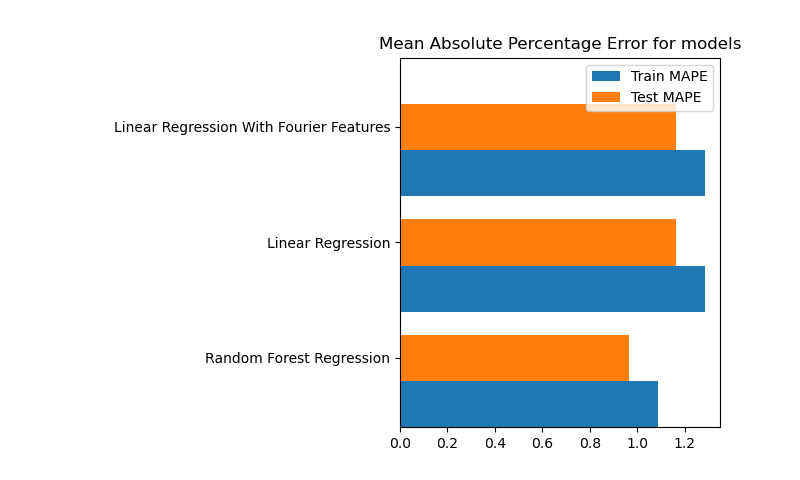

In [106]:
df = pd.DataFrame(dict(graph=['Random Forest Regression','Linear Regression','Linear Regression With Fourier Features'],n=train_mape, m=test_mape))
ind = np.arange(len(df))
width = 0.4
fig, ax = plt.subplots()
ax.barh(ind, df.n, width, label='Train MAPE')
ax.barh(ind + width, df.m, width, label='Test MAPE')
fig.set_figwidth(8)
plt.gcf().subplots_adjust(left = 0.5)
plt.title("Mean Absolute Percentage Error for models")
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.show()


Observation: 

    Random Forest Regression seems to be best model where MAPE of train value deacrease below 12%
    
    there is not any sign of overfitting or underfitting but Random forest model seems little bi overfitting
    
    all model have test MAPE in range of 12.6 to 13.6%
    